<a href="https://colab.research.google.com/github/jvjruiz/Duku-Tech-Test/blob/master/Term_Deposit_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background and Exploratory Data Analysis:

Background:

ACME is a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, at ACME we are looking to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

Data Description:

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

In [ ]:
# import necessary packages
import itertools
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix
from sklearn import svm
from matplotlib import pyplot as plt

Attributes:

age : age of customer (numeric)

job : type of job (categorical)

marital : marital status (categorical)

education (categorical)

default: has credit in default? (binary)

balance: average yearly balance, in euros (numeric)

housing: has a housing loan? (binary)

loan: has personal loan? (binary)

contact: contact communication type (categorical)

day: last contact day of the month (numeric)

month: last contact month of year (categorical)

duration: last contact duration, in seconds (numeric)

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

Output (desired target):

y - has the client subscribed to a term deposit? (binary)


In [ ]:
# initialize random_state for everything
random_state = 42

# load the data from google drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/ml_stuff/potential-talents.csv'
df = pd.read_csv(path)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: ignored

In [ ]:
print(df.dtypes)

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
y            object
dtype: object


Before throwing the data into any models, we should do some basic exploratory data analysis to get a better understanding, and also to see if we need to do any pre-processing on the data.

In [ ]:
# check if any values are null or empty, we if any are empty we have to do do some pre-processing
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

In [ ]:
# some stats on the features
df.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


Text(0.5, 1.0, 'Class Distributions')

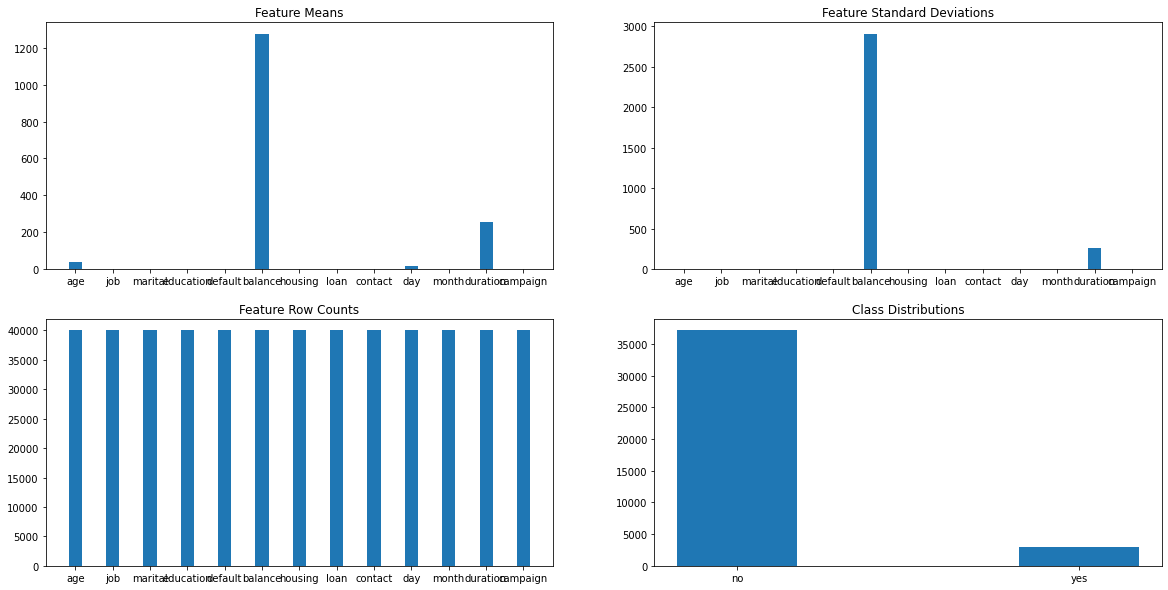

In [ ]:
# check distribution between classes
classes, class_counts = np.unique(df['y'], return_counts=True)
working_df = df.drop('y', axis=1)
means = working_df.describe(include='all').loc['mean']
stds = working_df.describe(include='all').loc['std']
counts = working_df.describe(include='all').loc['count']

labels = means.keys()

x = working_df.columns
width = 0.35  # the width of the bars


fig, ax = plt.subplots(2, 2, figsize=(20,10))

# display feature means
ax[0][0].bar(x, means, width)
ax[0][0].set_xticks(x)
ax[0][0].set_title('Feature Means')

# display standard deviations
ax[0][1].bar(x, stds, width)
ax[0][1].set_xticks(x)
ax[0][1].set_title('Feature Standard Deviations')

# display counts per feature
ax[1][0].bar(x, counts, width)
ax[1][0].set_xticks(x)
ax[1][0].set_title('Feature Row Counts')

# display class distribution
ax[1][1].bar(classes, class_counts, width)
ax[1][1].set_xticks(np.arange(2))
ax[1][1].set_xticklabels(classes)
ax[1][1].set_title('Class Distributions')



In [ ]:
df['y'].value_counts()

no     37104
yes     2896
Name: y, dtype: int64

So after taking a quick look at the statistics above we can learn a few things about the dataset.

1. The classes are heavily unbalanced. There is a factor of larger than 10 between the no's in the dataset and the yes'. We will definitely need to do something about that when training.
2. There are no missing values, which is good. We don't have to fill or delete any rows due to that reason.
3. It looks like balance, then duration have siginificantly higher values than the rest of the classes. Whether or not we will need to standardize these values is yet to be unseen, but it is a possibility.

# Data Transformation

### Transforming the binary columns

Currently the dataset is not usable in a machine learning model. Model's require integers to be able to gain meaning from the data. For example, models do not know the difference between the months January and March just by text, or even yes vs. no.

First let's change the yes/no columns into 1's and 0's. 1's will represent yes' and 0's will represent no's.

In [ ]:
# change yes and no values on y to 1 and 0
df.loc[df['y'] == 'yes', 'y'] = 1
df.loc[df['y'] == 'no', 'y'] = 0
df['y'] = df['y'].astype('int')

df.loc[df['loan'] == 'yes', 'loan'] = 1
df.loc[df['loan'] == 'no', 'loan'] = 0
df['loan'] = df['loan'].astype('int')

df.loc[df['housing'] == 'yes', 'housing'] = 1
df.loc[df['housing'] == 'no', 'housing'] = 0
df['housing'] = df['housing'].astype('int')

df.loc[df['default'] == 'yes', 'default'] = 1
df.loc[df['default'] == 'no', 'default'] = 0
df['default'] = df['default'].astype('int')

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,0


### Transforming Categorical Data


The dataset also contains categorical data. To be able to utilize this data, we must also transform the categories into numbers.

We can do this by changing the columns to datatype categories, the getting the category codes and inserting them into the dataframe as new columns.

In [ ]:
# change columns into categoricals
df['job'] = df['job'].astype('category')
df['job_cat'] = df['job'].cat.codes
df['marital'] = df['marital'].astype('category')
df['marital_cat'] = df['marital'].cat.codes
df['education'] = df['education'].astype('category')
df['education_cat'] = df['education'].cat.codes
df['month'] = df['month'].astype('category')
df['month_cat'] = df['month'].cat.codes
df['contact'] = df['contact'].astype('category')
df['contact_cat'] = df['contact'].cat.codes

In [ ]:
df.dtypes

age                 int64
job              category
marital          category
education        category
default             int64
balance             int64
housing             int64
loan                int64
contact          category
day                 int64
month            category
duration            int64
campaign            int64
y                   int64
job_cat              int8
marital_cat          int8
education_cat        int8
month_cat            int8
contact_cat          int8
dtype: object

In [ ]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y,job_cat,marital_cat,education_cat,month_cat,contact_cat
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,0,4,1,2,8,2
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,0,9,2,1,8,2
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,0,2,1,1,8,2
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,0,1,1,3,8,2
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,0,11,2,3,8,2


We can then remove the original categorical columns in the dataset, which leaves us with a dataset that consists of only numbers.

In [ ]:
# drop string features to make a df the models can work with
working_df = df.copy()

working_df = working_df.drop('job', axis=1)
working_df = working_df.drop('marital', axis=1)
working_df = working_df.drop('education', axis=1)
working_df = working_df.drop('month', axis=1)
working_df = working_df.drop('contact', axis=1)

working_df.head()

,age,default,balance,housing,loan,day,duration,campaign,y,job_cat,marital_cat,education_cat,month_cat,contact_cat
0,58,0,2143,1,0,5,261,1,0,4,1,2,8,2
1,44,0,29,1,0,5,151,1,0,9,2,1,8,2
2,33,0,2,1,1,5,76,1,0,2,1,1,8,2
3,47,0,1506,1,0,5,92,1,0,1,1,3,8,2
4,33,0,1,0,0,5,198,1,0,11,2,3,8,2


In [ ]:
working_df.dtypes

age              int64
default          int64
balance          int64
housing          int64
loan             int64
day              int64
duration         int64
campaign         int64
y                int64
job_cat           int8
marital_cat       int8
education_cat     int8
month_cat         int8
contact_cat       int8
dtype: object

# Resampling the data

As seen above, the classes in the dataset are severely unbalanced. There are two approaches to dealing with this problem, oversampling and undersampling.

### Undersampling the Data

As we undersample the data, we are getting the class with the lower amount of samples, then randomly sampling the class with the higher amount of samples. The result is a dataset that is perfectly balanced with a 1:1 ratio.

The caveat with this method is that we inherently have less data to work with in the dataset.

2896


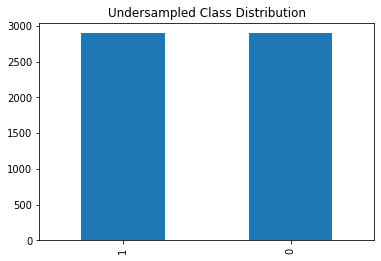

In [ ]:
# class counts
no_class_count, yes_class_count = working_df['y'].value_counts()
print(yes_class_count)

working_df[working_df['y'] == 1].head()

df_class_no_under = working_df[working_df['y'] == 0].sample(yes_class_count)

df_under = pd.concat([df_class_no_under, working_df[working_df['y'] == 1]], axis=0)

df_under['y'].value_counts().plot(kind='bar', title='Undersampled Class Distribution')

In [ ]:
df_under.describe()

,age,default,balance,housing,loan,day,duration,campaign,y,job_cat,marital_cat,education_cat,month_cat,contact_cat
count,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000
mean,40.263812,0.021754,1411.226865,0.546271,0.150207,15.831837,454.406595,2.627417,0.500000,4.375691,1.185773,1.252244,5.256388,0.558874
std,10.278213,0.145892,3001.612256,0.497897,0.357305,8.445363,408.905776,2.731335,0.500043,3.292627,0.634324,0.729343,3.066079,0.864696
min,19.000000,0.000000,-4057.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,0.000000,90.000000,0.000000,0.000000,8.000000,148.000000,1.000000,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000
50%,38.000000,0.000000,503.000000,1.000000,0.000000,16.000000,317.000000,2.000000,0.500000,4.000000,1.000000,1.000000,6.000000,0.000000
75%,48.000000,0.000000,1560.250000,1.000000,0.000000,22.000000,663.000000,3.000000,1.000000,7.000000,2.000000,2.000000,8.000000,2.000000
max,95.000000,1.000000,66721.000000,1.000000,1.000000,31.000000,3881.000000,37.000000,1.000000,11.000000,2.000000,3.000000,10.000000,2.000000


4690 samples in training set
580 samples in test set
522 samples in validation set


Text(0.5, 1.0, 'Test Class Distributions')

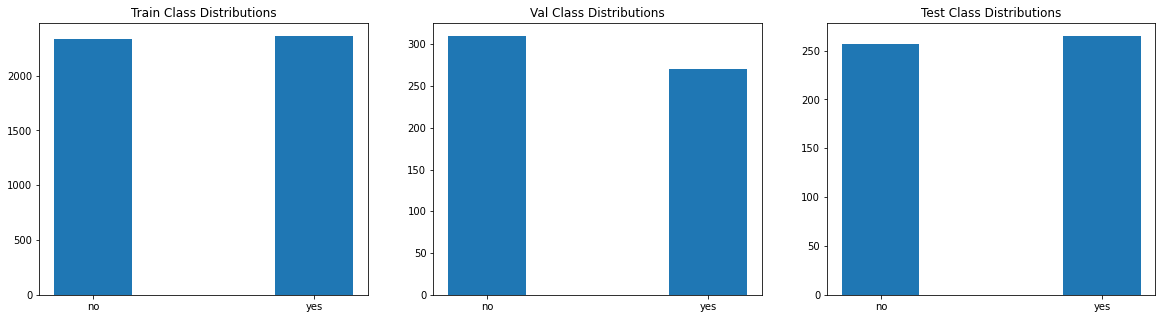

In [ ]:
# split dataset into training, validation, and test sets
X = df_under.drop('y', axis=1)
y = df_under['y']

# assign a validation set and save for model validation at the end after model selection
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X, y, test_size=.1, random_state=random_state)

X_train_under, X_val_under, y_train_under, y_val_under = train_test_split(X_train_under, y_train_under, test_size=.1, random_state=random_state)

# # stratify remaining data into train and test sets
# # stratifying data ensures that the datasets are balanced as possible
# sss = StratifiedShuffleSplit(n_splits=1, test_size=.1, random_state=random_state)

# for train_index, test_index in sss.split(X_train, y_train):
#   X_train, X_val = X.loc[train_index], X.loc[test_index]
#   y_train, y_val = y.loc[train_index], y.loc[test_index]

print("{} samples in training set".format(len(X_train_under)))
print("{} samples in test set".format(len(X_test_under)))
print("{} samples in validation set".format(len(X_val_under)))

train_unique_under, train_class_counts_under = np.unique(y_train_under, return_counts=True)
test_unique_under, test_class_counts_under = np.unique(y_test_under, return_counts=True)
val_unique_under, val_class_counts_under = np.unique(y_val_under, return_counts=True)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

# display train class distribution
ax1.bar(train_unique_under, train_class_counts_under, width)
ax1.set_xticks(np.arange(2))
ax1.set_xticklabels(classes)
ax1.set_title('Train Class Distributions')

# display val class distribution
ax2.bar(test_unique_under, test_class_counts_under, width)
ax2.set_xticks(np.arange(2))
ax2.set_xticklabels(classes)
ax2.set_title('Val Class Distributions')

# display test class distribution
ax3.bar(val_unique_under, val_class_counts_under, width)
ax3.set_xticks(np.arange(2))
ax3.set_xticklabels(classes)
ax3.set_title('Test Class Distributions')

### Oversampling the Data

Oversampling works the opposite from undersampling. With this method we take the class with the higher amount of samples, then continually randomly sample the class with the lower amount of samples until it reaches a 1:1 ratio. 

The caveat with this method is we may end up with models that are overfitted to the data.

2896


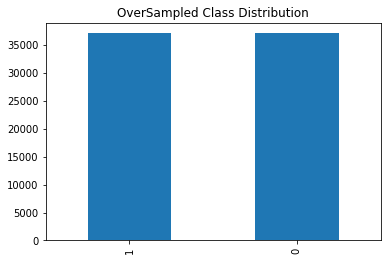

In [ ]:
# class counts
no_class_count, yes_class_count = working_df['y'].value_counts()
print(yes_class_count)


df_class_yes_over = working_df[working_df['y'] == 1].sample(no_class_count, replace=True)

df_over = pd.concat([df_class_yes_over, working_df[working_df['y'] == 0]], axis=0)

df_over['y'].value_counts().plot(kind='bar', title='OverSampled Class Distribution')

In [ ]:
df_over.describe()

,age,default,balance,housing,loan,day,duration,campaign,y,job_cat,marital_cat,education_cat,month_cat,contact_cat
count,74208.000000,74208.000000,74208.000000,74208.000000,74208.000000,74208.000000,74208.000000,74208.000000,74208.000000,74208.000000,74208.000000,74208.000000,74208.000000,74208.000000
mean,40.220273,0.018583,1406.119259,0.557245,0.154646,15.935357,453.989449,2.673553,0.500000,4.354692,1.183053,1.247359,5.305034,0.561435
std,10.300530,0.135047,2879.962988,0.496716,0.361570,8.423558,411.608459,2.874662,0.500003,3.282941,0.635099,0.733394,3.048985,0.865984
min,19.000000,0.000000,-8019.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,0.000000,91.000000,0.000000,0.000000,8.000000,147.000000,1.000000,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000
50%,38.000000,0.000000,493.000000,1.000000,0.000000,16.000000,312.000000,2.000000,0.500000,4.000000,1.000000,1.000000,6.000000,0.000000
75%,47.000000,0.000000,1544.000000,1.000000,0.000000,22.000000,664.000000,3.000000,1.000000,7.000000,2.000000,2.000000,8.000000,2.000000
max,95.000000,1.000000,102127.000000,1.000000,1.000000,31.000000,4918.000000,63.000000,1.000000,11.000000,2.000000,3.000000,10.000000,2.000000


60108 samples in training set
7421 samples in test set
6679 samples in validation set


Text(0.5, 1.0, 'Test Class Distributions')

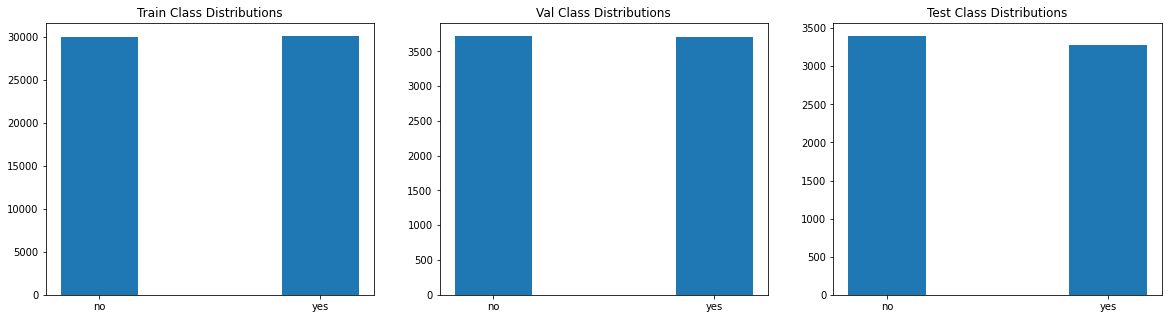

In [ ]:
# split dataset into training, validation, and test sets
X = df_over.drop('y', axis=1)
y = df_over['y']

# assign a validation set and save for model validation at the end after model selection
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X, y, test_size=.1, random_state=random_state)

X_train_over, X_val_over, y_train_over, y_val_over = train_test_split(X_train_over, y_train_over, test_size=.1, random_state=random_state)

# # stratify remaining data into train and test sets
# # stratifying data ensures that the datasets are balanced as possible
# sss = StratifiedShuffleSplit(n_splits=1, test_size=.1, random_state=random_state)

# for train_index, test_index in sss.split(X_train, y_train):
#   X_train, X_val = X.loc[train_index], X.loc[test_index]
#   y_train, y_val = y.loc[train_index], y.loc[test_index]

print("{} samples in training set".format(len(X_train_over)))
print("{} samples in test set".format(len(X_test_over)))
print("{} samples in validation set".format(len(X_val_over)))

train_unique_over, train_class_counts_over = np.unique(y_train_over, return_counts=True)
test_unique_over, test_class_counts_over = np.unique(y_test_over, return_counts=True)
val_unique_over, val_class_counts_over = np.unique(y_val_over, return_counts=True)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

# display train class distribution
ax1.bar(train_unique_over, train_class_counts_over, width)
ax1.set_xticks(np.arange(2))
ax1.set_xticklabels(classes)
ax1.set_title('Train Class Distributions')

# display val class distribution
ax2.bar(test_unique_over, test_class_counts_over, width)
ax2.set_xticks(np.arange(2))
ax2.set_xticklabels(classes)
ax2.set_title('Val Class Distributions')

# display test class distribution
ax3.bar(val_unique_over, val_class_counts_over, width)
ax3.set_xticks(np.arange(2))
ax3.set_xticklabels(classes)
ax3.set_title('Test Class Distributions')

# Model Fitting and Selection


First we set up a helper function to allow for grid search of hyperparameters on whatever classifier we throw in.

Using the Holdout grid search methodology, we are able to many different combinations of hyperparameters on our models, while saving the best performing one for further validation using our validation set.

For evaluation we are using F1-scores as shown by the equation below:

![Equation for calculating F1 Score, Precision, and Recall.](https://miro.medium.com/max/534/1*EXa-_699fntpUoRjZeqAFQ.jpeg)

Two metrics used to calculate F1 scores are precision and recall. 

As shown above, precision is calcuated by taking the total amount of true positives, items classified correctly, divided by sum of the total amount of true positives and false positives, or items that were incorrectly labeled positive or in this case happy.

Recall is calculated by taking the total number of true positives divided by the sum of the total amount of true positives and False Negatives, in this case customers that were misclassified as being unhappy.


In [ ]:
def holdout_grid_search(clf, X_train, y_train, X_test, y_test, hyperparams, fixed_hyperparams={}, verbose=True):
    '''
    Conduct hyperparameter grid search on hold out validation set. Use holdout validation.
    Hyperparameters are input as a dictionary mapping each hyperparameter name to the
    range of values they should iterate over. Use the cindex function as your evaluation
    function.

    Input:
        clf: sklearn classifier
        X_train_hp (dataframe): dataframe for training set input variables
        y_train_hp (dataframe): dataframe for training set targets
        X_val_hp (dataframe): dataframe for validation set input variables
        y_val_hp (dataframe): dataframe for validation set targets
        hyperparams (dict): hyperparameter dictionary mapping hyperparameter
                            names to range of values for grid search
        fixed_hyperparams (dict): dictionary of fixed hyperparameters that
                                  are not included in the grid search

    Output:
        best_estimator (sklearn classifier): fitted sklearn classifier with best performance on
                                             validation set
        best_hyperparams (dict): hyperparameter dictionary mapping hyperparameter
                                 names to values in best_estimator
    '''
    
    best_estimator = None
    best_hyperparams = {}
    
    # hold best running score
    best_score = 0.0

    # get list of param values
    lists = hyperparams.values()
    
    # get all param combinations
    param_combinations = list(itertools.product(*lists))
    total_param_combinations = len(param_combinations)


    # iterate through param combinations
    for i, params in enumerate(param_combinations, 1):

        # fill param dict with params
        param_dict = {}
        for param_index, param_name in enumerate(hyperparams):
            param_dict[param_name] = params[param_index]
            
        # create estimator with specified params
        estimator = clf(**param_dict, **fixed_hyperparams)

        # fit estimator
        estimator.fit(X_train, y_train)
        
        # score the test set
        y_preds = estimator.predict(X_test)
        f_score = f1_score(y_test, y_preds)


        # if new high score, update high score, best estimator
        # and best params 
        if f_score >= best_score:
                if (verbose):
                  print(f'New Best Score: {f_score}\n')
                  print("{}\n".format(param_dict))
                best_score = f_score
                best_estimator = estimator
                best_hyperparams = param_dict

    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)
    
    return best_estimator, best_hyperparams

## Logistic Regression Classifier

First we will try using a simple logistic regression classifier to find a baseline level model.

Logistic regression is commonly used as a binary classification algorithm, but can be expanded for multiple classes. 

What is important here is the algorithm will provide a probability on which class the item belong's to, or in this case whether or not a customer is happy. After calculating the probabilities, the model returns the class with the higher probability score.

In [ ]:
def logistic_regression_grid_search(X_train, y_train, X_test, y_test, verbose=True):

    hyperparams = {
        # Inverse Regularization Strength
        'C': [0.001, 0.01, 0.1, 1.0, 10.0],

        # determine class weights for classifier, default is None
        # balanced automatically adjusts weights
        'class_weight': [None, 'balanced'],

        'solver': ['liblinear'],

        # max iterations for solver to converge
        'max_iter': [100, 150, 200]
    }

    
    fixed_hyperparams = {
        'random_state': 42,
    }
    
    logr = LogisticRegression

    best_logr, best_hyperparams = holdout_grid_search(logr, X_train, y_train,
                                                    X_test, y_test, hyperparams,
                                                    fixed_hyperparams, verbose)

    print(f"Best hyperparameters:\n{best_hyperparams}")

    # score the train and test sets
    y_train_preds = best_logr.predict(X_train)
    f_score_train_best = f1_score(y_train, y_train_preds)
    print(f"Train Score: {f_score_train_best}")

    y_test_preds = best_logr.predict(X_test)
    f_score_test_best = f1_score(y_test, y_test_preds)
    print(f"Test Score: {f_score_test_best}")
    
    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)
    
    return best_logr, best_hyperparams, f_score_test_best

In [ ]:
best_logr_under, best_hyperparams, best_logr_score_under = logistic_regression_grid_search(X_train_under, y_train_under, X_val_under, y_val_under)

New Best Score: 0.805668016194332

{'C': 0.001, 'class_weight': None, 'solver': 'liblinear', 'max_iter': 100}

New Best Score: 0.805668016194332

{'C': 0.001, 'class_weight': None, 'solver': 'liblinear', 'max_iter': 150}

New Best Score: 0.805668016194332

{'C': 0.001, 'class_weight': None, 'solver': 'liblinear', 'max_iter': 200}

New Best Score: 0.8178137651821863

{'C': 0.01, 'class_weight': None, 'solver': 'liblinear', 'max_iter': 100}

New Best Score: 0.8178137651821863

{'C': 0.01, 'class_weight': None, 'solver': 'liblinear', 'max_iter': 150}

New Best Score: 0.8178137651821863

{'C': 0.01, 'class_weight': None, 'solver': 'liblinear', 'max_iter': 200}

New Best Score: 0.8225806451612903

{'C': 0.1, 'class_weight': None, 'solver': 'liblinear', 'max_iter': 100}

New Best Score: 0.8225806451612903

{'C': 0.1, 'class_weight': None, 'solver': 'liblinear', 'max_iter': 150}

New Best Score: 0.8225806451612903

{'C': 0.1, 'class_weight': None, 'solver': 'liblinear', 'max_iter': 200}

New 

In [ ]:
best_logr_over, best_hyperparams, best_logr_score_over = logistic_regression_grid_search(X_train_over, y_train_over, X_val_over, y_val_over)


New Best Score: 0.789599617163822

{'C': 0.001, 'class_weight': None, 'solver': 'liblinear', 'max_iter': 100}

New Best Score: 0.789599617163822

{'C': 0.001, 'class_weight': None, 'solver': 'liblinear', 'max_iter': 150}

New Best Score: 0.789599617163822

{'C': 0.001, 'class_weight': None, 'solver': 'liblinear', 'max_iter': 200}

New Best Score: 0.7925251557259223

{'C': 0.01, 'class_weight': None, 'solver': 'liblinear', 'max_iter': 100}

New Best Score: 0.7925251557259223

{'C': 0.01, 'class_weight': None, 'solver': 'liblinear', 'max_iter': 150}

New Best Score: 0.7925251557259223

{'C': 0.01, 'class_weight': None, 'solver': 'liblinear', 'max_iter': 200}

New Best Score: 0.7926576217079009

{'C': 0.01, 'class_weight': 'balanced', 'solver': 'liblinear', 'max_iter': 100}

New Best Score: 0.7926576217079009

{'C': 0.01, 'class_weight': 'balanced', 'solver': 'liblinear', 'max_iter': 150}

New Best Score: 0.7926576217079009

{'C': 0.01, 'class_weight': 'balanced', 'solver': 'liblinear', '

In [ ]:
data = {
    'Oversampled F1 Score': best_logr_score_over,
    'Undersampled F1 Score': best_logr_score_under
}

logr_df = pd.DataFrame(data=data, index=[0])

logr_df.head()

,Oversampled F1 Score,Undersampled F1 Score
0,0.794061,0.827586


Looks like this algorithm only works slightly better with the undersampled dataset at a F1 score of .83 vs .80.

## K-Nearest Neighbors (KNN)

KNN algorithm works by plotting new datapoints next to labeled datapoints. Then it will take the overall class of the closest N datapoints and assign it to the new datapoint.

In [ ]:
def KNN_grid_search(X_train, y_train, X_test, y_test, verbose=True):

    hyperparams = {
        # Number of neighbors used for calculation
        'n_neighbors': [2, 3, 4, 5],

        # distance parameter, 1 = manahattan, 2 = euclidean
        'p': [1, 2]
    }

    
    fixed_hyperparams = {
    }
    
    KNN = KNeighborsClassifier

    best_KNN, best_hyperparams = holdout_grid_search(KNN, X_train, y_train,
                                                    X_test, y_test, hyperparams,
                                                    fixed_hyperparams, verbose)

    print(f"Best hyperparameters:\n{best_hyperparams}")

    # score the train and test sets
    y_train_preds = best_KNN.predict(X_train)
    f_score_train_best = f1_score(y_train, y_train_preds)
    print(f"Train Score: {f_score_train_best}")

    y_test_preds = best_KNN.predict(X_test)
    f_score_test_best = f1_score(y_test, y_test_preds)
    print(f"Test Score: {f_score_test_best}")
    
    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)
    
    return best_KNN, best_hyperparams, f_score_test_best

In [ ]:
best_KNN_under, best_hyperparams_under, best_KNN_score_under = KNN_grid_search(X_train_under, y_train_under, X_val_under, y_val_under)

New Best Score: 0.6977777777777778

{'n_neighbors': 2, 'p': 1}

New Best Score: 0.7082405345211581

{'n_neighbors': 2, 'p': 2}

New Best Score: 0.7755905511811024

{'n_neighbors': 3, 'p': 1}

New Best Score: 0.7912524850894632

{'n_neighbors': 5, 'p': 1}

Best hyperparameters:
{'n_neighbors': 5, 'p': 1}
Train Score: 0.8330807534098289
Test Score: 0.7912524850894632


In [ ]:
best_KNN_over, best_hyperparams_over, best_KNN_score_over = KNN_grid_search(X_train_over, y_train_over, X_val_over, y_val_over)

New Best Score: 0.96941941202541

{'n_neighbors': 2, 'p': 1}

New Best Score: 0.9715724015398283

{'n_neighbors': 2, 'p': 2}

Best hyperparameters:
{'n_neighbors': 2, 'p': 2}
Train Score: 1.0
Test Score: 0.9715724015398283


In [ ]:
data = {
    'Oversampled F1 Score': best_KNN_score_over,
    'Undersampled F1 Score': best_KNN_score_under
}

knn_df = pd.DataFrame(data=data, index=[0])

knn_df.head()

,Oversampled F1 Score,Undersampled F1 Score
0,0.971572,0.791252


Here it looks like the oversampled KNN model performed amazingly with an F1 score of 1 on the training set, and .97 on the validation set.

We will look into this deeper to ensure that this is not the result of overfitting.

## Guassian Naive Bayes

Next we will try the Gaussian Naive Bayes algorithm. This implements the Bayes algorithm and assumes that all features are independent of each other. 

If this proves to be useful, we can re-train the algorithm down the line with partial fit to avoid having to re-train the entire thing.

In [ ]:
def GNB_grid_search(X_train, y_train, X_test, y_test, verbose=True):

    hyperparams = {
        # Inverse Regularization Strength
        'var_smoothing': [1e-9, 1e-7, 1e-5, 1e-3, 1e-1, 1],

    }

    
    fixed_hyperparams = {
        
    }
    
    gnb = GaussianNB

    best_gnb, best_hyperparams = holdout_grid_search(gnb, X_train, y_train,
                                                    X_test, y_test, hyperparams,
                                                    fixed_hyperparams, verbose)

    print(f"Best hyperparameters:\n{best_hyperparams}")

    
    # score the train and test sets
    y_train_preds = best_gnb.predict(X_train)
    f_score_train_best = f1_score(y_train, y_train_preds)
    print(f"Train Score: {f_score_train_best}")

    y_test_preds = best_gnb.predict(X_test)
    f_score_test_best = f1_score(y_test, y_test_preds)
    print(f"Test Score: {f_score_test_best}")
    
    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)
    
    return best_gnb, best_hyperparams, f_score_test_best

In [ ]:
best_gnb_under, best_hyperparams_under, best_gnb_score_under = GNB_grid_search(X_train_under, y_train_under, X_val_under, y_val_under)

New Best Score: 0.7951807228915662

{'var_smoothing': 1e-09}

New Best Score: 0.810234541577825

{'var_smoothing': 1e-07}

Best hyperparameters:
{'var_smoothing': 1e-07}
Train Score: 0.7723749119097956
Test Score: 0.810234541577825


In [ ]:
best_gnb_over, best_hyperparams_over, best_svc_score_over = GNB_grid_search(X_train_over, y_train_over, X_val_over, y_val_over)

New Best Score: 0.7887368255466416

{'var_smoothing': 1e-09}

Best hyperparameters:
{'var_smoothing': 1e-09}
Train Score: 0.7996926229508198
Test Score: 0.7887368255466416


In [ ]:
data = {
    'Oversampled F1 Score': best_svc_score_over,
    'Undersampled F1 Score': best_gnb_score_under
}

gnb_df = pd.DataFrame(data=data, index=[0])

gnb_df.head()

,Oversampled F1 Score,Undersampled F1 Score
0,0.788737,0.810235


Looks like the oversample and undersampled datasets performed very closely with F1 scores of .79.

## Random Forest Classifier

Next we will try a random forest classifier to see if we can get better performance. Random forest classifiers are an esemble method algorithm. They work by fitting a set amount of decision tree's and averaging the result from them. Using the random forest method generally helps improve accuracty and helps manage over-fitting, which is a common issue with using a single decision tree. 

The reason we are trying this one last is because this algorithm typically uses the most resources due to the robustness of the algorithm. If we can get similar or better performance with a simpler algorithm, it would be a better to use in the long run when the dataset becomes larger.


In [ ]:
def random_forest_grid_search(X_train, y_train, X_test, y_test, verbose=True):

    # Define ranges for the chosen random forest hyperparameters 
    hyperparams = {
        # how many trees should be in the forest (int)
        'n_estimators': [2,5,10,25,50],

        # the maximum depth of trees in the forest (int)
        'max_depth': [1,2,5,8],
        
        # the minimum number of samples in a leaf as a fraction
        'min_samples_leaf': [.5,1,2],

        # the minimum number of samples to split an internal node
        'min_samples_split': [.5,2,3,4]
    }

    
    fixed_hyperparams = {
        'random_state': random_state,
    }
    
    rf = RandomForestClassifier

    best_rf, best_hyperparams = holdout_grid_search(rf, X_train, y_train,
                                                    X_test, y_test, hyperparams,
                                                    fixed_hyperparams, verbose)

    print(f"Best hyperparameters:\n{best_hyperparams}")

            
    # score the train and test sets
    y_train_preds = best_rf.predict(X_train)
    f_score_train_best = f1_score(y_train, y_train_preds)
    print(f"Train Score: {f_score_train_best}")

    y_test_preds = best_rf.predict(X_test)
    f_score_test_best = f1_score(y_test, y_test_preds)
    print(f"Train Score: {f_score_test_best}")

    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)
    
    return best_rf, best_hyperparams, f_score_test_best

In [ ]:
best_rf_under, best_hyperparams_under, best_rf_score_under = random_forest_grid_search(X_train_under, y_train_under, X_val_under, y_val_under)

New Best Score: 0.6734434561626429

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 0.5, 'min_samples_split': 0.5}

New Best Score: 0.6734434561626429

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 0.5, 'min_samples_split': 2}

New Best Score: 0.6734434561626429

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 0.5, 'min_samples_split': 3}

New Best Score: 0.6734434561626429

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 0.5, 'min_samples_split': 4}

New Best Score: 0.8066528066528066

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 0.5}

New Best Score: 0.8066528066528066

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}

New Best Score: 0.8066528066528066

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 3}

New Best Score: 0.8066528066528066

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 4}

New Best Score: 0.8066528066

In [ ]:
best_rf_over, best_hyperparams_over, best_rf_score_over = random_forest_grid_search(X_train_over, y_train_over, X_val_over, y_val_over)

New Best Score: 0.6588353413654618

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 0.5, 'min_samples_split': 0.5}

New Best Score: 0.6588353413654618

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 0.5, 'min_samples_split': 2}

New Best Score: 0.6588353413654618

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 0.5, 'min_samples_split': 3}

New Best Score: 0.6588353413654618

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 0.5, 'min_samples_split': 4}

New Best Score: 0.777981041077665

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 0.5}

New Best Score: 0.777981041077665

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}

New Best Score: 0.777981041077665

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 3}

New Best Score: 0.777981041077665

{'n_estimators': 2, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 4}

New Best Score: 0.77798104107766

In [ ]:
data = {
    'Oversampled F1 Score': best_rf_score_over,
    'Undersampled F1 Score': best_rf_score_under
}

rf_df = pd.DataFrame(data=data, index=[0])

rf_df.head()

,Oversampled F1 Score,Undersampled F1 Score
0,0.884023,0.870406


Again it seems that the model performed nearly equally as well on the oversampled and undersampled datasets.


## Evaluation

Below we will take a look a how each model above performs on the validation sets that were set aside from the beggining. This will show how the model's perform on data they have not seen before. 


In [ ]:
best_clfs_under = [best_gnb_under, best_logr_under, best_rf_under, best_KNN_under]
classifier_labels = ['Gaussian Naive Bayes', 'Logistic Regression', 'Random Forest', 'KNN Classifer']
test_f1_scores = []

for clf in best_clfs_under:
  y_test_preds = clf.predict(X_test_under)
  test_f1_score = f1_score(y_test_under, y_test_preds)
  test_f1_scores.append(test_f1_score)


test_df = pd.DataFrame(np.array(test_f1_scores), index=classifier_labels, columns=['F1 Scores for Undersampled Dataset'])

test_df.head()

,F1 Scores for Undersampled Dataset
Gaussian Naive Bayes,0.770791
Logistic Regression,0.778420
Random Forest,0.833333
KNN Classifer,0.747170


In [ ]:
best_clfs_over = [best_gnb_over, best_logr_over, best_rf_over, best_KNN_over]
classifier_labels = ['Gaussian Naive Bayes', 'Logistic Regression', 'Random Forest', 'KNN Classifier']
test_f1_scores = []

for clf in best_clfs_over:
  y_test_preds = clf.predict(X_test_over)
  test_f1_score = f1_score(y_test_over, y_test_preds)
  test_f1_scores.append(test_f1_score)


test_df = pd.DataFrame(np.array(test_f1_scores), index=classifier_labels, columns=['F1 Scores for Oversampled Dataset'])

test_df.head()

,F1 Scores for Oversampled Dataset
Gaussian Naive Bayes,0.801621
Logistic Regression,0.807908
Random Forest,0.882400
KNN Classifier,0.971894


We can visualize these results using confusion matrices to see how each model predicted each class.

A confusion matrix works by showing the true label on the Y-axis and the Predicted Label on the X-Axis. This allows us to see how many were guessed correctly per class and how many times the items were misclassified on other classes. This is especially useful if we have more than two classes to see not only how many are being misclassified, but how which class it is being misclassified as.



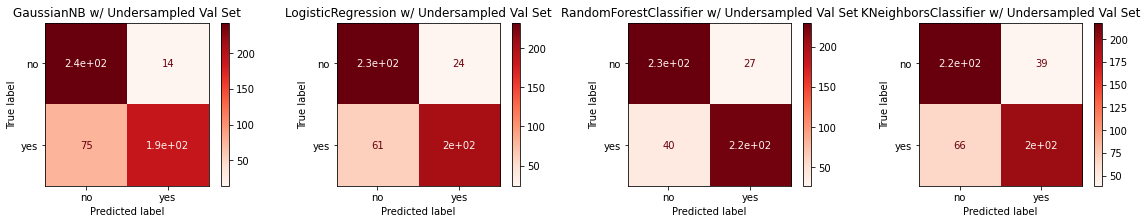

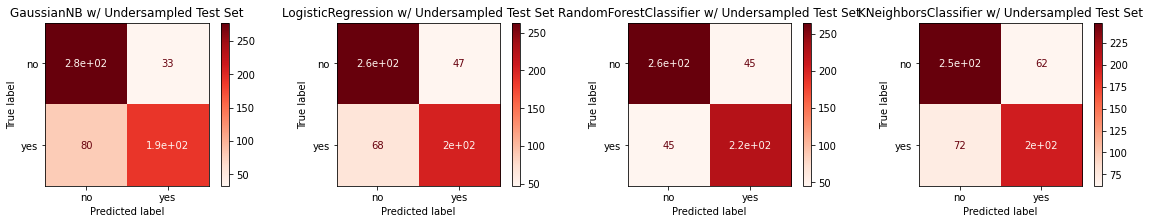

In [ ]:
# plot confusion matrices
fig, ax = plt.subplots(1, 4, figsize=(20,3))

# plot validation confusion matrices
for clf, ax in zip(best_clfs_under, ax.flatten()):
  plot_confusion_matrix(clf,
                        X_val_under,
                        y_val_under,
                        ax=ax,
                        cmap='Reds',
                        display_labels=classes)
  ax.title.set_text("{} w/ Undersampled Val Set".format(type(clf).__name__))

fig2, ax2 = plt.subplots(1, 4, figsize=(20,3))

# plot test set confusion matrices
for clf, ax2 in zip(best_clfs_under, ax2.flatten()):
  plot_confusion_matrix(clf,
                      X_test_under,
                      y_test_under,
                      ax=ax2,
                      cmap='Reds',
                      display_labels=classes)
  ax2.title.set_text("{} w/ Undersampled Test Set".format(type(clf).__name__))

  
plt.show()



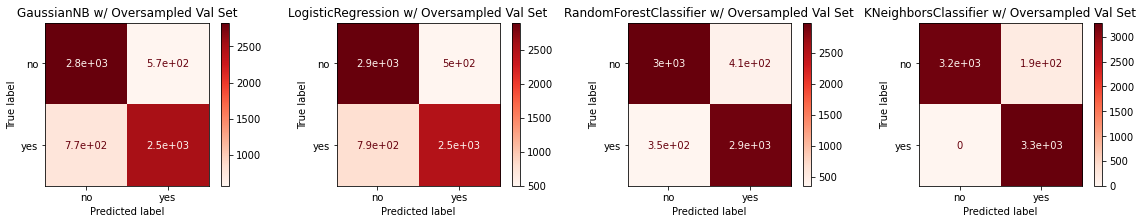

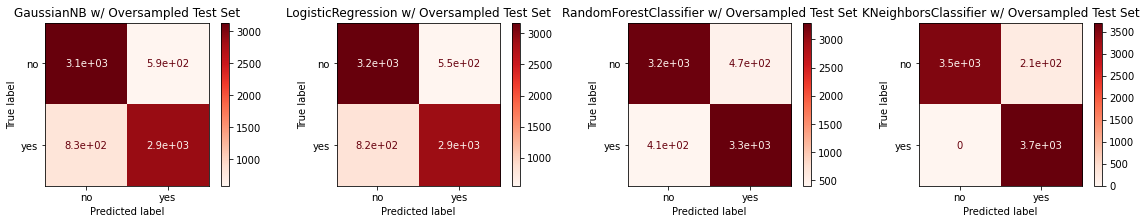

In [ ]:
# plot confusion matrices
fig, ax = plt.subplots(1, 4, figsize=(20,3))

# plot validation confusion matrices
for clf, ax in zip(best_clfs_over, ax.flatten()):
  plot_confusion_matrix(clf,
                        X_val_over,
                        y_val_over,
                        ax=ax,
                        cmap='Reds',
                        display_labels=classes)
  ax.title.set_text("{} w/ Oversampled Val Set".format(type(clf).__name__))

fig2, ax2 = plt.subplots(1, 4, figsize=(20,3))

# plot test set confusion matrices
for clf, ax2 in zip(best_clfs_over, ax2.flatten()):
  plot_confusion_matrix(clf,
                      X_test_over,
                      y_test_over,
                      ax=ax2,
                      cmap='Reds',
                      display_labels=classes)
  ax2.title.set_text("{} w/ Oversampled Test Set".format(type(clf).__name__))

  
plt.show()



By using confusion matrices, we are able to see that the models are not just learning one class and overly guessing it to achieve higher accuracy metrics. The dark colors down the diagonal mean that the models are guessing the correct class a majority of the time for both classes.

### K-Fold Cross Validation

K-Fold Cross Validation is a method that allows us to see how a model performs on different sets of the dataset. It works by seperating the data into "K" folds, and reserves a set of the data in each fold for a vaidation set. The model then trains on the unreserved data in each of the folds, then validates the results with the reserved data.

In [ ]:
X = working_df.drop('y', axis=1)
y = working_df['y']

folds = 5 

undersampled_scores = cross_val_score(best_rf_under, X, y, cv=folds, scoring='f1_weighted')
oversampled_scores = cross_val_score(best_KNN_over, X, y, cv=folds, scoring='f1_weighted')

avg_undersampled_score = np.sum(undersampled_scores)/folds
avg_oversampled_score = np.sum(oversampled_scores)/folds

d = {
    'Avg Oversampled F1 Score': avg_oversampled_score,
    'Avg Undersampled F1 Score': avg_undersampled_score
}

cv_df = pd.DataFrame(data=d, index=[0])

cv_df.head()

,Avg Oversampled F1 Score,Avg Undersampled F1 Score
0,0.905116,0.795322


The metrics above were generated by taking the best performing model for the oversampled and undersampled data. We can see that the model's performed slightly worse, but this was expected as we threw in the dataset without and undersampling or oversampling. This gives us a better idea on how the models would perform in the real world.

## Bonus(es):

We are also interested in finding customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.




Attributes:

age : age of customer (numeric)

job : type of job (categorical)

marital : marital status (categorical)

education (categorical)

default: has credit in default? (binary)

balance: average yearly balance, in euros (numeric)

housing: has a housing loan? (binary)

loan: has personal loan? (binary)

contact: contact communication type (categorical)

day: last contact day of the month (numeric)

month: last contact month of year (categorical)

duration: last contact duration, in seconds (numeric)

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

Output (desired target):

y - has the client subscribed to a term deposit? (binary)


In [ ]:
# pull up df and drop category interger 
analysis_df = df.drop(['marital_cat', 'education_cat', 'month_cat', 'contact_cat', 'job_cat'], axis=1)

analysis_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,0


In [ ]:
# filter out customers that didn't buy the investment product
analysis_df = analysis_df[analysis_df['y'] == 1]

analysis_df.describe()

,age,default,balance,housing,loan,day,duration,campaign,y
count,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.0
mean,39.844959,0.016920,1588.495856,0.505525,0.131215,15.827003,682.958564,2.414365,1.0
std,11.001984,0.128994,2924.894429,0.500056,0.337694,8.557604,431.287174,2.306015,0.0
min,19.000000,0.000000,-3058.000000,0.000000,0.000000,1.000000,8.000000,1.000000,1.0
25%,31.000000,0.000000,141.000000,0.000000,0.000000,8.000000,364.000000,1.000000,1.0
50%,37.000000,0.000000,620.000000,1.000000,0.000000,16.000000,629.000000,2.000000,1.0
75%,47.000000,0.000000,1820.500000,1.000000,0.000000,22.000000,913.000000,3.000000,1.0
max,95.000000,1.000000,45248.000000,1.000000,1.000000,31.000000,3881.000000,32.000000,1.0


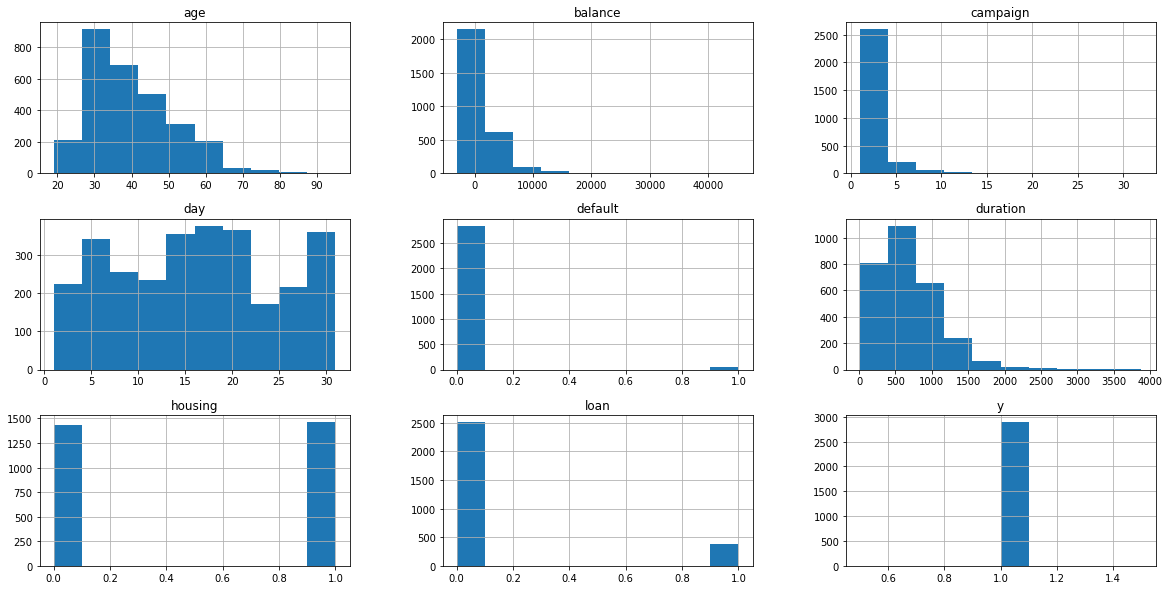

In [ ]:
# first lets plot a histogram of the features that can be represented as numerics
hist = analysis_df.hist(figsize=(20,10))

Based on the histograms above, a few things can be inferred by looking at the distributions of the features. The most notable things that stand out are the following:
1. The age of the typical customer is around 30 and gets smaller over time. This is not surprising as around 30 is when adults start getting real monetary improvements in their lives, and thinking about investing in the future increases. It is likely that adults in this age range are buying longer term notes to maximize their investment potential. The counts for age groups after this seem to drop in a linear fashion, meaning as people get older, they are less likely to buy a term deposit, for various reasons.
2. Overwhelmingly people that have not defaulted on a loan are more likely to buy a term deposit. This can hint that people that are more fiscally responsible are more likely to invest into their future.
3. A possibly surprising statistic is the balance in their accounts. People with lower balances are more likely to make investments. This can be taken in several different ways and needs more investigation.
4. The amount of customers that already have loans are more likely to get a term deposit. This may mean that they are more trusting of financial institutions and therefore are more likely to buy into a term deposit.
5. The features duration and campaign can be observed together. According to the data, people don't like to be over bothered. A low amount of campaign calls and a short call time seem to be the sweet spot for customer aquisition.

Next let's take a look at the distribution of the categorical features.

In [ ]:
marital_counts

married     1478
single      1027
divorced     391
Name: marital, dtype: int64

Text(0.5, 1.0, 'Contact Class Distributions')

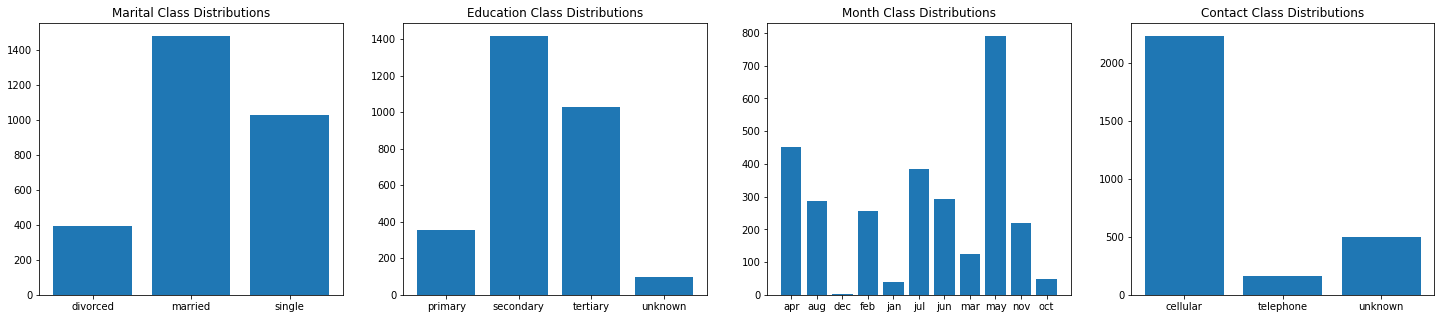

In [ ]:
# 'marital_cat', 'education_cat', 'month_cat', 'contact_cat', 'job_cat'

marital_classes, marital_counts = np.unique(analysis_df['marital'], return_counts=True)
education_classes, education_counts = np.unique(analysis_df['education'], return_counts=True)
month_classes, month_counts = np.unique(analysis_df['month'], return_counts=True)
job_classes, job_counts = np.unique(analysis_df['job'], return_counts=True)
contact_classes, contact_count = np.unique(analysis_df['contact'], return_counts=True)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25,5))

# display martial distribution
ax1.bar(x=range(len(marital_counts)), height=marital_counts)
ax1.set_xticks(range(len(marital_counts)))
ax1.set_xticklabels(marital_classes)
ax1.set_title('Marital Class Distributions')

# display val class distribution
ax2.bar(x=range(len(education_counts)), height=education_counts)
ax2.set_xticks(range(len(education_counts)))
ax2.set_xticklabels(education_classes)
ax2.set_title('Education Class Distributions')

# display test class distribution
ax3.bar(x=range(len(month_counts)), height=month_counts)
ax3.set_xticks(range(len(month_counts)))
ax3.set_xticklabels(month_classes)
ax3.set_title('Month Class Distributions')

# display train class distribution
ax4.bar(x=range(len(contact_count)), height=contact_count)
ax4.set_xticks(range(len(contact_count)))
ax4.set_xticklabels(contact_classes)
ax4.set_title('Contact Class Distributions')

According to the distributions above a few things can be inferred:
1. Married people are more likely to purchase than the other two classes. This may be because they have more security and a stronger dual income if both parties are working. The divorcees are more likely worrying about finding stability than setting up for future stability.
2. It is not surprising that higher education leads to higher sales for investment products. What is surprising is that secondary are more likely to purchase than teritiary. This needs deeper investigation.
3. The month people tend to purchase definitely needs more investigation. The only inference I can make without more is it is not surprising that nobody is buying investments around December holidays or a historically slow for business January.
4. Seems like people are more likely to purchase if contacted by cellphone, although this needs deeper investigation.

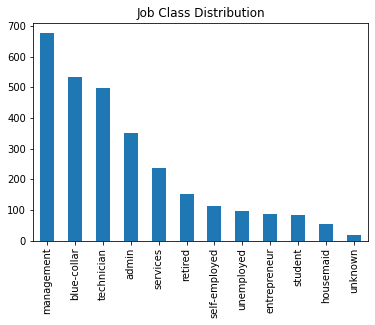

In [ ]:
analysis_df['job'].value_counts().plot(kind='bar', title='Job Class Distribution')

Analysis of the jobs is interesting. While not surprising that people in management are more likely to buy into the term deposits, the blue-collar statistic surprised me. 

It is not surprising that retired, entrepreneur and student are lower on the list. Students likely don't have the expendable resources to spend on investments, retirees are towards the end of their lifespans and therefore would not benefit as much from long term investments, and entrepreneurs are more likely investing in themselves and their businesses than long term investment products like this.

What makes the customers buy? Tell us which feature we should be focusing more on.

Feature: age, Score: 0.029847546970843294
Feature: default, Score: 0.0006383479961417844
Feature: balance, Score: 0.02298107633192568
Feature: housing, Score: 0.022737149611826702
Feature: loan, Score: 0.004474570446133519
Feature: day, Score: 0.042367024799498144
Feature: duration, Score: 0.7170707999414926
Feature: campaign, Score: 0.013499546877782202
Feature: job_cat, Score: 0.005199295095346958
Feature: marital_cat, Score: 0.008433975208539418
Feature: education_cat, Score: 0.00889091682621027
Feature: month_cat, Score: 0.07430941967050997
Feature: contact_cat, Score: 0.04955033022374948


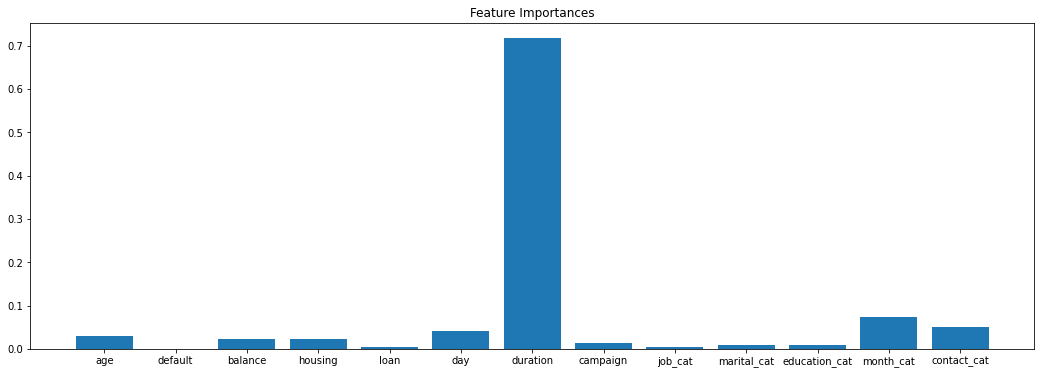

In [ ]:
feature_importances = best_rf_over.feature_importances_
features = X_train_over.columns.tolist()

# summarize feature importance
for i,v in enumerate(feature_importances):
	print('Feature: {}, Score: {}'.format(features[i],v))
 
# plot feature importance
plt.figure(figsize=(18,6))
plt.title('Feature Importances')
plt.bar(features, feature_importances)

plt.show()

The graph above shows the feature importances of each feature. This depicts how influential the feature was for the random forest to make a classification decision on a row. We can use this data to gain insight on what drives a customers decision, and if we can remove any to make the survey shorter.

According to the graph, by far the most important feature was the duration columns. Using this and knowing the data from the above charts, we can assume that shorter calls meant higher chance of landing a sale. 

The next features that can be analyzed and focused on more would be month, age, type of contact, and the amount of days since the last contact.



baseline model performance
try dropping the duration feature
more visualization
